<a href="https://colab.research.google.com/github/joheeeeeeeee/AI-/blob/main/potHole%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 포트홀 탐지 모델 만들기
## 포트홀이란
   1. 포트홀은 도로에 만들어진 크랙의 종류로 깊게 패인 웅덩이를 말한다.
   2. 포트홀을 탐지 하는 목적은
      -. 자율 주행 자동차의 안전을 위한 회피 운행
      -. 도로 보수를 위한 위치 탐색

## 응용 SW를 개발하는 방법
    1. What ? : 위의 정의와 같이 무엇을 할 것인지를 정한다.
    2. DataSet을 준비 한다. : 학습을 위한 annotation된 dataSet를 준비 한다.
    3. 적합한 Pre-Trained된 모델을 구한다. : 이미지 관련서 우리는 YOLO에 집중한다.
    4. Fine-Tunning : 2에서 준비한 dataSet을 이용하여 custom Model을 만든다.
    5. 응용 SW를 제작한다
        -. webAPP : 실습한 TM을 이용한 JS를 기억한다.
        -. nativeAPP : python과 pyQT5를 이용한 배포가능한 setup.exe까지 완성한것을 기억한다.

## YOLO 클로닝

In [ ]:
# 현재 폴더
%pwd
# 위치 이동을 강제로 해야 한다면
%cd /content/
%pwd

In [ ]:
# github에서 YOLO 가져오기 https://github.com/ultralytics/yolov5
!git clone https://github.com/ultralytics/yolov5

## 작업폴더로 이동


In [ ]:
%cd yolov5

In [ ]:
# dataSet를 가져올 폴더를 만듬
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

## dataSet를 가져 오기
### 인공지능은 무조건 데이터이다
양질의 데이터를 구하는것이 승패를 좌우한다
### 데이터세트를 구할수있는곳은
1. roboflow.com 에서는 모델과 코드를 함께제공
2. kaggle
3. aihub.go.kr등or kr일수도있음 기억이 가물*2
직접 구글링을 통해서 다양한 데아터 세트를 아용할줄알면좋아요
특히 aihub.or.kr에서는 데이터댐사업으ㄹ 통해 구축된 세트를 사용할수있음 경우에따라서 데이터바우처를 이용해서 풀데이터세트를 받아올수있음

In [ ]:
!curl -L "https://public.roboflow.com/ds/AZZeoZCGOT?key=XFPYdCUU9Z" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
%pwd

## dataSet의 구성 내용을 확인

In [ ]:
from glob import glob
train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/valid/images/*.jpg')
print(len(train_img_list), len(test_img_list), len(valid_img_list))


`glob` 모듈은 파일 경로를 패턴 매칭하여 파일들의 리스트를 반환해주는 데 사용됩니다. 주로 디렉토리 내의 파일을 다룰 때 유용하게 쓰입니다. 예를 들어, 특정 확장자를 가진 파일을 모두 가져오거나 특정 패턴과 일치하는 파일들을 찾을 때 사용될 수 있습니다. 이를 통해 파일을 다루는 프로그램에서 파일들을 쉽게 처리할 수 있게 됩니다. 이런 기능들을 사용하여 파일 시스템을 탐색하거나 특정 파일들을 처리하는 작업을 할 때 유용하게 활용될 수 있습니다.

## 모델 FineTunning을 시작

## 1. 데이터세트의 위치등을 알려주기 위한 yaml 파일 준비

### 윗줄에서 만든 list를 txt 파일로 저장한다.

In [ ]:
import yaml
with open('/content/yolov5/pothole/train.txt','w') as f:
    f.write('\n'.join(train_img_list) + '\n')
with open('/content/yolov5/pothole/test.txt','w') as f:
    f.write('\n'.join(test_img_list) + '\n')
with open('/content/yolov5/pothole/val.txt','w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

`yaml` 모듈은 YAML(YAML Ain't Markup Language) 형식의 데이터를 파이썬 객체로 읽거나 파이썬 객체를 YAML 형식으로 쓰는 데 사용됩니다. YAML은 사람이 읽기 쉽고 쓰기 쉬운 데이터 직렬화 형식으로, 특히 설정 파일이나 데이터 저장 및 전송에 자주 사용됩니다. 예를 들어, YAML 형식의 설정 파일을 파이썬으로 읽어들여서 설정값을 로드하거나, 파이썬 객체를 YAML 형식의 문자열로 변환하여 파일에 저장할 때 사용할 수 있습니다. 이를 통해 데이터를 텍스트 형식으로 효과적으로 저장하고 전달할 수 있습니다.

### fineTunning중에 자주 사용하는 writetemplate 함수를 정의한다.

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

이 코드는 IPython 환경에서 사용할 수 있는 사용자 정의 매직 명령어를 등록하는 데 사용됩니다. IPython은 Python 인터프리터의 개선된 버전으로, 사용자가 쉽게 확장하고 사용자 정의 기능을 추가할 수 있도록 하는 환경을 제공합니다.

여기서 `@register_line_cell_magic` 데코레이터는 사용자가 정의한 함수를 IPython의 라인 매직이나 셀 매직으로 사용할 수 있도록 만들어줍니다. 이 경우 `writetemplate` 함수가 정의되어 있고, 이 함수는 라인 매직 또는 셀 매직으로 사용될 수 있습니다.

`writetemplate` 함수는 두 개의 매개변수 `line`과 `cell`을 받습니다. `line`은 매직 명령어가 호출될 때 입력된 라인에 대한 문자열이고, `cell`은 셀 매직으로 사용될 때 셀 전체에 대한 문자열입니다.

이 함수는 `open()` 함수를 사용하여 `line`에 지정된 파일을 쓰기 모드로 엽니다. 그리고 이 파일 객체를 이용하여 `cell`에 있는 문자열을 해당 파일에 씁니다. `{}`을 사용하여 문자열 포맷팅을 수행하는데, `globals()` 함수를 통해 현재 전역 네임스페이스에 있는 변수들을 가져와서 해당 문자열에 적용합니다. 이를 통해 전역 변수들의 값을 템플릿 문자열에 삽입할 수 있습니다.

이 코드를 사용하면 IPython 환경에서 파일을 생성하고 내용을 템플릿 형태로 작성할 수 있습니다. 이렇게 작성된 파일은 파일명을 매직 명령어의 인자로 지정하여 생성됩니다.

### FineTunning중에 모델에게 dataSet의 위치를 알려 주기 위한 data.yaml을 만든다

In [ ]:
%%writetemplate /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [ ]:
%cat /content/yolov5/pothole/data.yaml

### 만들어진 data.yaml에서 필요한 변수(nc)를 가져오기

In [ ]:
with open('/content/yolov5/pothole/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])
  print (num_classes)

### custom_yolov5s.yaml을 만들기    
    1. 원래 pre-trained된yolov5s.yaml이 갖고 있는 내용을 수정해서 만들어야 함.
        -. 원본 yolov5s.yaml을 cat으로 프린트 해서
        -. 복사한여 사용한다.
    2. 원래 있던 yaml 내용중 ,nc 부분만 수정해 준다.

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

### custom_yolov5s.yaml 파일을 만든다.

    * nc : 80 또는 nc : 다른숫자
    부분을 앞서 가져온 변수 num_classes로 바꾸어 준다. {num_classes}

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

### 최종 만들어진 custom_yolov5s.yaml의 내용중 nc가 수정되었는지 확인
nc = num_classes = 1

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml

## 2. 학습 시작

### 학습에 필요한 parameter 지정하기
    -. 우리가 사용하는 train.py는 yoloV5 모델을 발표한 사람이 직접 작성한 코드이다.
    -. 우리는 1줄의 수정없이 코드를 그대로 사용하여 fine Tunjning을 진행한다.
    -. 다만 parameter를 이용해서 작업 방법을 알려준다 **굵은 텍스트**


* `img`: 입력 이미지 크기 정의
* `batch`: 배치 크기 결정
* `epochs`: 학습 기간 개수 정의
* `data`: yaml 파일 경로
* `cfg`: 모델 구성 지정
* `weights`: 가중치에 대한 경로 지정
* `name`: 결과 이름
* `nosave`: 최종 체크포인트만 저장
* `cache`: 빠른 학습을 위한 이미지 캐시

### 학습을 위해서 폴더 이동하고 시간 기록하기



In [ ]:
import time
%cd /content/yolov5/
%time


### train.py에 파라메타 전달하고 실행하기

### 아래 코드를 실행중 래러가 발생 할 수 있어요
    1. 원인은 ultralytics의 gitpython 모듈이 설치가 안되어
    2. 자동 설치 하고 다시 restart 되면서
    3, /content/yolov5/pothole/train/labels.cache  가 만들어졌기 때문
    4. 이 파일을 제거 한후
    5. 아래 코드를 재 실행 하면 됩니다.

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 50 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pothole_result  --cache

### 결과 확인
    1. 먼저 최종 결과를 확인하면 다음과 같다.
    custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:02<00:00,  2.33it/s]
                   all        133        330      0.588      0.482      0.524      0.249
Results saved to runs/train/pothole_result2
CPU times: user 3.18 s, sys: 473 ms, total: 3.65 s
Wall time: 5min 1s
    2. 성적이 매우 좋지 않은것을 볼수 있다. mAP가 0.5?
    3. epoch,를 더 했어야 한다.
    

2. tensorboard를 이용한 확인

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

    3. 학습 과정중에 validation data를 이용하여 스스로 검증한 결과를 이미지로 출려한 내용을 확인 할 수 있읍니다.

In [ ]:
# train을 실행 할때마다 폴더가 생기므로 !ls /content/yolov5/runs/train/pothole_results/를 아래와 같이 수정해주었다 (경우에 따라 다르므로 확인 필요함)
!ls /content/yolov5/runs/train/pothole_result2

### 검증

### 실제로 검증 과정은 앞서 확인한 텐서 보드의 내용과 동일하다.

    1. 가중치 파일은 우리가 파인튜닝한 것을 사용한다.
    2. /content/yolov5/runs/train/pothole_result2/weights/best.pt 는 학습 과정중 가장 성적이 좋은것이다.
    

In [ ]:
!python val.py --weights /content/yolov5/runs/train/pothole_result2/weights/best.pt --data /content/yolov5/pothole/data.yaml --img 640 --iou 0.65 --half

### 추론 (Inference)
    1. 이제는 실제 사용하기 위해서 시뮬레이션을 시작
    2. test 데이터를 이용한다.
    3. 앞서 yolov5를 사용해서 Object detection을 했던 것 처럼
    4. 이번에는 우리가 만든 모델(파인튜닝한)을 이용해서 Object Detection을 한다.
    

파인튜닝한 결과물이 저장된 (best.pt) 위치를 확인해서 폴더 위치를 지정해 주어야 한다

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/pothole_result2/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

결과물 확인

In [ ]:
import glob
import random
from IPython.display import Image, display
# 여기도 폴더 위치를 확인하세요
image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))

display(Image(filename=image_name))

###모델을 파인튜닝해서 custom Model을 만드는 과정이 끝났습니다.

# 애써 만든 best.pt를 어딘가에 저장해 둡니다.
## 구글드라이브나 혹은 내 컴퓨터에 다운로드 하고 이름을 pothole20240429.pt 로 저장해 두고
### 나중에 만들게되는 응용 프로그램에서 사용하게 됩니다.

1. 구글드라이브를 연결 한다면

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%mkdir /content/drive/MyDrive/pothole
%cp /content/yolov5/runs/train/pothole_result/weights/best.pt /content/drive/MyDrive/pothole

2. 바로 다운로드 한다면

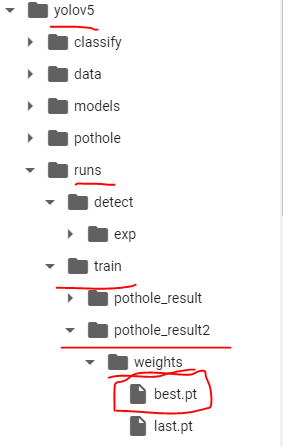